# Quordle

If the ⬜🟨🟩 emoji look famliar to you, you may have, like most of us, been playing a lot of [Wordle][wordle].

But what if Wordle was played on a quantum computer --- and with just 5 bits?

## Rules of Wordle

In case you're not familiar with Wordle, here's how it's played: there's a five letter word you need to guess. You're given 6 tries to guess it. After each try, you're told:
- Which letters of your word are **not** in the word to guess,
- Which letters of your word **are** in the word to guess, but in the wrong position,
- Which letters of your word are in the word to guess, and in the **correct** position.

Since there's some 6000-ish (or more) 5-word letters, this means you'll need at least 12 bits to represent each guess.

## Bringing Wordle to the Quantum Wordl

### The Bloch Sphere

But now, imagine you're given 5 quantum bits: one for each letter to guess. We'll keep it simple and leave them unentangled to play nice with NISQ.

In these conditions, each qubit, by virtue of being quantum, is actually described by a full 2D-space, with some particular periodic conditions; in fact, the state of each qubit is well represented by a sphere, the so-called Bloch sphere:

![Bloch Sphere --- Smite-Meister on Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6b/Bloch_sphere.svg/451px-Bloch_sphere.svg.png)

The catch is that you don't observe this sphere, or the φ, or θ angles. Instead, you're only allowed to pick some direction of projection (a diameter of the sphere, in the above reprensentation), and will observe either a **yes** or **no** outcome, based on how the state is projected on the direction of measurement. This is easier to see in practice; consider that you're measuring along the blue direction, and you have a blue, a red, an orange, a purple, and a green state. Each has a different projection along our chosen direction, and corresponding probabilities:

![Overlaps](assets/bloch_overlap.png)

Furthermore, every state that lives in the red equator will have the same projection along the blue axis --- and therefore the same probability of observing `yes` or `no` --- **even though they're different states**.

There's another catch: if you estimate `p(NO)` as the relative frequency of `NO` in a number of shots, then, for a limited number of shots, there's some error margin in your estimation.

### Rules of Quordle

In Quordle, every letter lives in the Bloch sphere. The word you need to guess, then, is given by five states on five Bloch spheres.

In each round, your guess (which **must be a valid word**) will define five bases to project the different qubits onto. As a reply, you'll get the frequencies with which you observed a `no` on each qubit.

![Letters on the sphere](assets/bloch_sphere_with_letters.png)

Imagine that you're trying to guess `QUBIT`, and have guessed `CLASS`. For the first qubit, you should get a fairly high probability of observing `NO`:

![Q and S overalp](assets/qs_overlap.png)

However, there are other letters near `Q` that are compatible with that probability: 

![Other possibilities](assets/qs_alternative.png)

By trying different words and looking at the Bloch sphere and the measurements you get, try to find the hidden word in the least number of guesses! ([Psst: you'll be doing state tomography!][tomography])

**Remember the catch:** If there's a low number of shots, or a lot of noise, the probabilities reported may be inaccurate!

### Playing Quordle

You can play Quordle in the `Quordle.ipynb` notebook (follow the instructions there to set up the game). After each guess, you'll see a Bloch sphere, and a keyboard showing the `no` measurement frequencies for each letter. By clicking a letter, you can examine the letters in the Bloch sphere that are compatible with the observed frequency. (To help you out, letters that are likely are opaque and green, and letters that are unlikely are red and transparent.)


[wordle]: https://www.powerlanguage.co.uk/wordle/
[tomography]: https://en.wikipedia.org/wiki/Quantum_tomography

---

## Building Quordle

Below, you'll find the code we used to build the frontend for Quordle. It's split into the various parts we needed: figuring out what state to keep, drawing a Bloch sphere on the screen, placing the letters cleverly on the sphere, and making the interface dynamically respond to clicks, so you can examine the Bloch sphere of each letter.

In [1]:
%pip install ipycanvas

You should consider upgrading via the '/home/miguelmurca/.pyenv/versions/iquhack/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from collections import namedtuple
import numpy as np

In [3]:
# Let's start by describing the state in terms of `namedtuple`s.
# This will give us an idea of how to organize the code below,
# by detatching state from the visualization.
# We consider our state immutable.

Guess = namedtuple(
    'Guess', [
        'word', # str: the word the player has guessed.
        'probabilities', # list[list[float]; 26]; 5]
                         #   the probability for each letter we
                         #   got for each letter of the guess.
        'shots', # int: the number of shots used for this guess.
    ])

State = namedtuple(
    'State', [
        'word', # str: the word the player has to guess.
        'guesses', # tuple[Guess]; guesses[-1] is the most recent guess.
    ])

In [4]:
# The probabilities here are bogus!
# We just want to make sure that things render correctly.
example_state = State(
    word='qubit',
    guesses=[
        Guess(
            word='quack',
            probabilities=[
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,)))],
            shots=100),
        Guess(
            word='james',
            probabilities=[
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,)))],
            shots=450),
        Guess(
            word='toast',
            probabilities=[
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,)))],
            shots=10),
        Guess(
            word='slide',
            probabilities=[
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,))),
                list(np.random.uniform(size=(26,)))],
            shots=100),
    ])

In [5]:
# Step one: draw the five Wordle squares :)
# We'll be using ipycanvas for this.
from ipycanvas import Canvas, Path2D, hold_canvas

In [6]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [7]:
def draw_letter_space(canvas, start_at, letter=None):
    """Draws one of those hollow rounded rectangles.
    
    Arguments:
        canvas:   Canvas         The canvas to draw to.
        start_at: Tuple[int,int] The top-left corner of the rectangle to be drawn
        letter:   str?           A single letter to draw inside the rectangle.
                                 If None, no letter is drawn.
    Returns:
        Nothing.
    """
    roundness = 10
    top = 25
    side = 50
    
    canvas.begin_path()
    x, y = start_at
    canvas.move_to(x, y + roundness)
    x, y = x, y + roundness
    canvas.arc_to(x, y - roundness, x + roundness, y - roundness, roundness)
    x, y = x + roundness, y - roundness
    canvas.line_to(x + top, y)
    x, y = x + top, y
    canvas.arc_to(x + roundness, y, x + roundness, y + roundness, roundness)
    x, y = x + roundness, y + roundness
    canvas.line_to(x, y + side)
    x, y = x, y + side
    canvas.arc_to(x, y + roundness, x - roundness, y + roundness, roundness)
    x, y = x - roundness, y + roundness
    canvas.line_to(x - top, y)
    x, y = x - top, y
    canvas.arc_to(x - roundness, y, x - roundness, y - roundness, roundness)
    x, y = x - roundness, y - roundness
    canvas.line_to(x, y - side)
    canvas.line_width = 2
    canvas.line_cap = 'round'
    canvas.stroke()
    
    if letter is not None:
        x, y = start_at
        center_x, center_y = x + (roundness*2 + top)/2, y + (roundness*2 + side)/2
        baseline = 10
        
        kern = 1
        canvas.font = '32px sans-serif'
        canvas.text_align = 'center'
        canvas.fill_text(letter, center_x + kern, center_y + baseline)


In [8]:
def display_word(canvas, word, position=(50, 20), space=50):
    """Shows a (five-letter) word in squares.
    
    Arguments:
        canvas: Canvas               The canvas to draw to.
        word: str                    The word to draw.
                                      Expected to be 5-letter long.
        position: Tuple[int, int]?   The (x,y) at which to start
                                      drawing [default: (50, 20)].
        space: int?                  How much to skip for
                                      each square [default: 100].
    Returns:
        Nothing.
    """
    to_space_and_letter =  lambda x: (position[0] + x[0]*space, x[1])
    for h_offset, letter in map(to_space_and_letter, enumerate(word)):
        draw_letter_space(canvas, (h_offset, position[1]), letter)

In [9]:
canvas = Canvas(width=620, height=400)
for i, word in enumerate(('qubit', 'quack', 'james', 'hello')):
    display_word(canvas, word, position=(50, 20 + 100*i))
canvas

Canvas(height=400, width=620)

In [10]:
# Step two: Show a Bloch sphere!

In [11]:
%pip install matplotlib

You should consider upgrading via the '/home/miguelmurca/.pyenv/versions/iquhack/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import matplotlib.pyplot as plt
# import numpy as np
from matplotlib import cm

In [13]:
%matplotlib inline

In [14]:
# Kind of a HACK; but this is on Matplotlib! It's hard to convince
# it to show a (1,1,1) aspect ratio on 3d plots.
# This is from John Henckel, https://stackoverflow.com/a/70522240/1564310
def set_aspect_equal(ax):
    """ 
    Fix the 3D graph to have similar scale on all the axes.
    Call this after you do all the plot3D, but before show
    """
    X = ax.get_xlim3d()
    Y = ax.get_ylim3d()
    Z = ax.get_zlim3d()
    a = [X[1]-X[0],Y[1]-Y[0],Z[1]-Z[0]]
    b = np.amax(a)
    ax.set_xlim3d(X[0]-(b-a[0])/2,X[1]+(b-a[0])/2)
    ax.set_ylim3d(Y[0]-(b-a[1])/2,Y[1]+(b-a[1])/2)
    ax.set_zlim3d(Z[0]-(b-a[2])/2,Z[1]+(b-a[2])/2)
    ax.set_box_aspect(aspect = (1,1,1))


In [15]:
def draw_sphere(ax):
    """Draws a sphere on the provided ax."""
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    # alpha controls opacity
    ax.contour3D(x, y, z, 30, alpha=0.8, linewidths=.5, cmap='binary')

In [16]:
def draw_line(ax, from_point, to_point, density=200, *args, **kwargs):
    """Draws a straight line in 3D in the ax.
    
    Arguments:
        ax: Axes                         The ax instance to draw to.
                                          (Usually from add_subplot or similar)
        from_point: tuple[float; 3]      Where to start the line (x,y,z).
        to_point: tuple[float; 3]        Where to end the line (x,y,z).
        density: float?                  Number of intermediate points to sample.
        *args                            Passed to ax.plot
        **kwargs                         Passed to ax.plot
    Returns:
        Nothing.
    """
    xpoints = np.linspace(from_point[0], to_point[0], density)
    ypoints = np.linspace(from_point[1], to_point[1], density)
    zpoints = np.linspace(from_point[2], to_point[2], density)
    ax.plot(xpoints, ypoints, zpoints, *args, **kwargs)

In [17]:
def draw_axis(ax):
    """Draws the XYZ axis around (0,0,0) on the ax."""
    length = 1.1
    color_x, color_y, color_z = cm.get_cmap('viridis')(np.linspace(0,1,3))[0: 3]
    draw_line(ax, (0,0,0), (length,0,0), color=color_x)
    draw_line(ax, (0,0,0), (0,length,0), color=color_y)
    draw_line(ax, (0,0,0), (0,0,length), color=color_z)
    ax.text(length + .2, 0, 0, 'x', color=color_x)
    ax.text(0, length + .2, 0, 'y', color=color_y)
    ax.text(0, 0, length + .2, 'z', color=color_z)

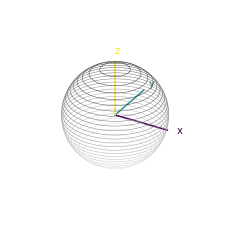

In [18]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.grid(visible=None)
ax.axis('off')
ax.tick_params(labelsize=8)

draw_axis(ax)
draw_sphere(ax)

set_aspect_equal(ax)
plt.show()

In [19]:
# Interlude: How should we distribute the letters in the Bloch sphere?
# Sure, we could just place them as regularly as possible, but it makes
# more sense to try to keep common letters away from each other.

# Here's the available positions...
positions = [(0,0),
             (1,0),
             (0.5,0.5),
             (0.5,-0.5),
             (0.5,0),
             (-0.5,0),
             (0.5,0.25),
             (0.5,0.75),
             (0.5,1.25),
             (0.5,1.75),
             (0.25,0),
             (0.75,0),
             (1.25,0),
             (1.75,0),
             (0.25,0.5),
             (0.75,0.5),
             (0.75,-0.5),
             (0.25,-0.5),
             (0.25,0.25),
             (0.25,0.75),
             (0.25,1.25),
             (0.25,1.75),
             (0.75,0.25),
             (0.75,0.75),
             (0.75,1.25),
             (0.75,1.75)]

In [20]:
# # And let's see what's the distribution of letters on our wordlist
abs_freq = {}
with open('wordlist.txt', 'r') as wordlist_buf:
    for word in wordlist_buf.readlines():
        for letter in word.strip().upper():
            abs_freq[letter] = abs_freq.get(letter, 0) + 1

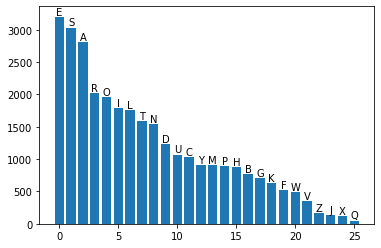

In [21]:
fig = plt.figure()
ax = fig.subplots()
sorted_keys = sorted(list(abs_freq.keys()), key=lambda k: abs_freq[k], reverse=True)
ax.bar(np.arange(len(sorted_keys)), [abs_freq[k] for k in sorted_keys])

rects = ax.patches
for rect, label in zip(rects, sorted_keys):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
    
plt.show()

In [22]:
# So now, the best positioning of the letters will be the combination that
# maximizes sum(f(i)*f(j)*d(i,j) for all pairs of letters (i,j)),
# where f(i) is the (relative) frequency of letter i, and d(i,j) can be,
# for simplicity, the Cartesian distance between letters i and j.

# This isn't necessarily easily to optimally solve, so we'll take a heuristic
# approach:
# Start with the most common letter, and place it anywhere.
# Then, for each letter in the order of most to least common,
#  find the position that maximizes the above quantity.

candidate_positions = list(positions)
letter_positions = []
letter_position_keys = []

total = sum(abs_freq.values())
rel_freq = { k: v/total for k,v in abs_freq.items()}

def cartesian_distance(a, b):
    x0, y0 = a
    x1, y1 = b
    return (x0 - x1)**2 + (y0 - y1)**2

for letter in sorted_keys:
    best_score = None
    best_position_index = None
    best_position = None
    for position_index, position in enumerate(candidate_positions):
        score = sum(
            rel_freq[letter] * rel_freq[other] * cartesian_distance(position, letter_positions[i])
            for i, other in enumerate(sorted_keys[:len(letter_positions)]))
        
        if best_score is None or score > best_score:
            best_position_index = position_index
            best_position = position
            best_score = score
    
    candidate_positions.remove(best_position)
    letter_positions.append(best_position)
    letter_position_keys.append(position_index)

print([l for i, l in sorted(enumerate(sorted_keys), key=lambda ik: letter_position_keys[0])])

['E', 'S', 'A', 'R', 'O', 'I', 'L', 'T', 'N', 'D', 'U', 'C', 'Y', 'M', 'P', 'H', 'B', 'G', 'K', 'F', 'W', 'V', 'Z', 'J', 'X', 'Q']


In [23]:
#%pip install qiskit

In [24]:
from aux_functions import *

In [25]:
def add_letter_labels(ax, colors=None, *args, **kwargs):
    """Adds the 26 letters to the Bloch sphere."""
    positions = [(0,0),
                 (1,0),
                 (0.5,0.5),
                 (0.5,-0.5),
                 (0.5,0),
                 (-0.5,0),
                 (0.5,0.25),
                 (0.5,0.75),
                 (0.5,1.25),
                 (0.5,1.75),
                 (0.25,0),
                 (0.75,0),
                 (1.25,0),
                 (1.75,0),
                 (0.25,0.5),
                 (0.75,0.5),
                 (0.75,-0.5),
                 (0.25,-0.5),
                 (0.25,0.25),
                 (0.25,0.75),
                 (0.25,1.25),
                 (0.25,1.75),
                 (0.75,0.25),
                 (0.75,0.75),
                 (0.75,1.25),
                 (0.75,1.75)]
    #letter_dist = {'a':0,'b':1,'c':2,'d':3,'e':4,'f':5,'g':6,
    #               'h':7,'i':8,'j':9,'k':10,'l':11,'m':12,
    #               'n':13,'o':14,'p':15,'q':16,'r':17,'s':18,
    #               't':19,'u':20,'v':21,'w':22,'x':23,'y':24,'z':25}
    letter_dist = ['E', 'S', 'A', 'R', 'O', 'I', 'L', 'T', 'N', 'D', 'U',
                   'C', 'Y', 'M', 'P', 'H', 'B', 'G', 'K', 'F', 'W', 'V',
                   'Z', 'J', 'X', 'Q']
    
    sim = Aer.get_backend('statevector_simulator')
    points = []
    for letter in letter_dist:
        circ = word_circuit(letter, {l:i for i,l in enumerate(letter_dist)}, positions, 1, inverse=False)
        point = sim.run(circ).result().get_statevector()
        norm = np.abs(point)
        angle = np.angle(point)
        angle = angle[1] - angle[0]
        theta = 2*np.arccos(norm[0])
        points.append([np.cos(angle)*np.sin(theta), np.sin(angle)*np.sin(theta), np.cos(theta)])

    for i, point in enumerate(points):
        color = 'b' if colors is None else colors[i]
        marker = '$' + letter_dist[i] + '$'
        ax.plot(*point, marker=marker, color=color, lw=0, *args, **kwargs)

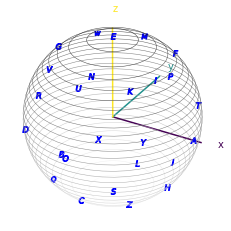

In [26]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.grid(visible=None)
ax.axis('off')
ax.tick_params(labelsize=8)
ax.dist = 6

draw_axis(ax)
draw_sphere(ax)
add_letter_labels(ax)

set_aspect_equal(ax)
plt.show()

In [27]:
# We'll need a way to color each letter based on the probability.
# This function converts the probabilities in alphabetical order to
# colors.
def probabilities_to_colors(probabilities):
    """Convert letter probabilities to colors."""
    probabilities = np.array(probabilities)
    colors = cm.get_cmap('RdYlGn')(probabilities)
    #colors = np.flip(colors, axis=0)
    # cm.get_map()() gets us an array of [r, g, b, a];
    # We wish the colors to fade out.
    colors[:,-1] = probabilities[:]
    return colors

In [28]:
def plot_letters(ax, probabilities):
    """Plot the letter distribution on a Bloch sphere."""
    ax.grid(visible=None)
    ax.axis('off')
    ax.tick_params(labelsize=8)
    ax.dist = 6

    draw_axis(ax)
    draw_sphere(ax)
    add_letter_labels(ax, colors=probabilities_to_colors(probabilities), markersize=15)

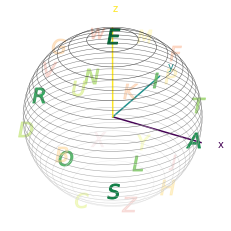

In [29]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_letters(ax, np.linspace(1., 0., 26))
set_aspect_equal(ax)
plt.show()

In [30]:
# Step 3: Render a State

In [31]:
def render_guess(guess):
    """Render a Guess."""
    canvas = Canvas(width=980, height=100)
    with hold_canvas(canvas):
        display_word(canvas, guess.word, position=(50, 20), space=205)
    display(canvas)

    fig = plt.figure()
    fig.set_size_inches(25, 5)
    axs = fig.subplots(1, 5)

    for i, letter_set in enumerate(guess.probabilities):
        axs[i].remove()
        ax = fig.add_subplot(1, 5, i+1, projection='3d')
        plot_letters(ax, letter_set)
        set_aspect_equal(ax)
    plt.show()

def render_state(state):
    """Render all the Guesses of a State."""
    # Show the guesses so far
    for guess in state.guesses:
        render_guess(guess)

Canvas(height=100, width=980)

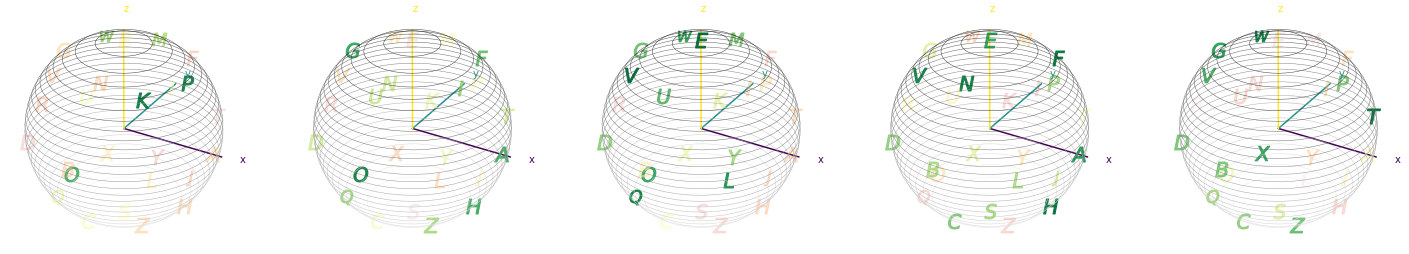

Canvas(height=100, width=980)

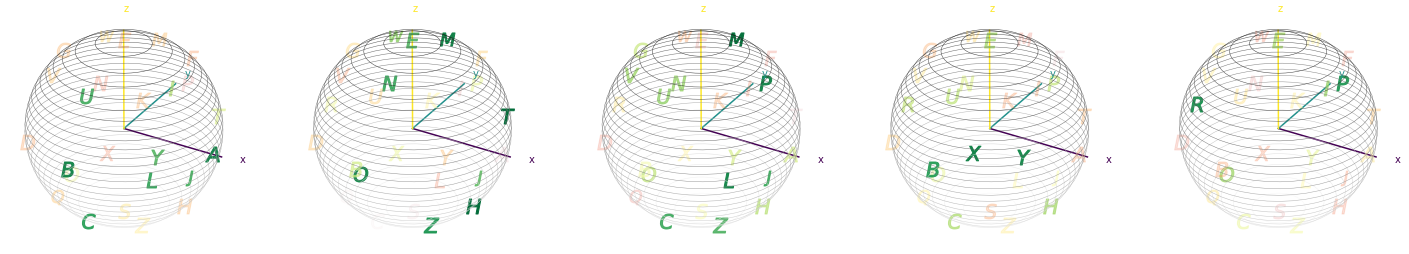

Canvas(height=100, width=980)

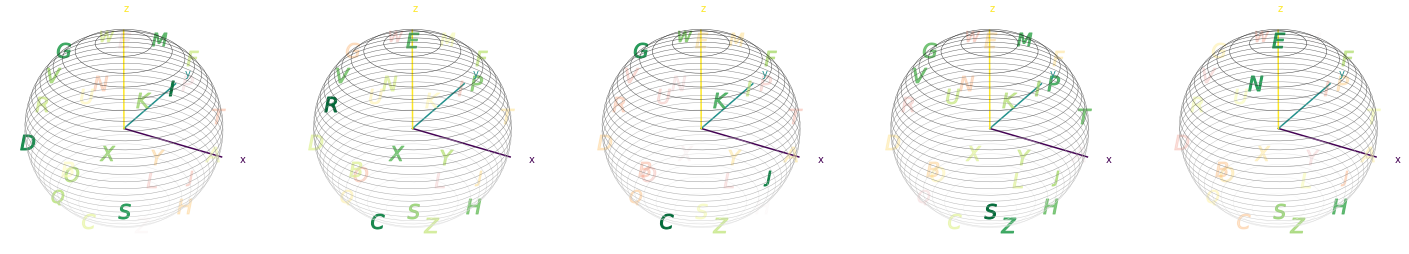

Canvas(height=100, width=980)

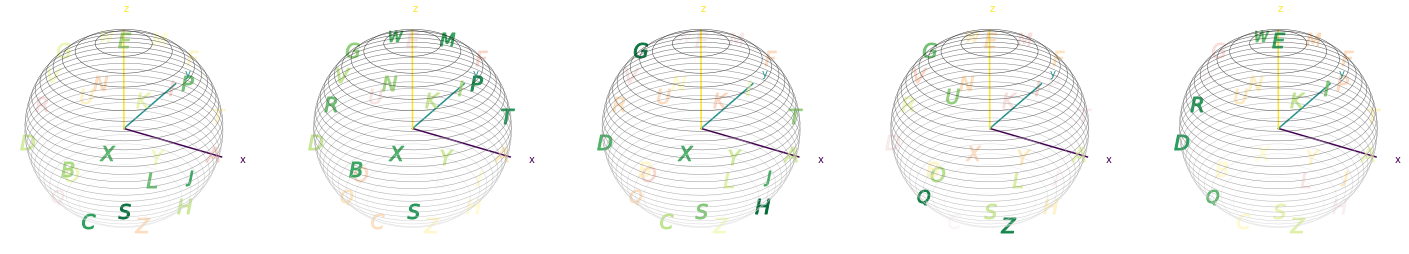

In [32]:
%matplotlib inline
render_state(example_state)

In [33]:
# Step 4: Show a single sphere (interactive)

In [34]:
%pip install ipympl

You should consider upgrading via the '/home/miguelmurca/.pyenv/versions/iquhack/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [35]:
def render_interactive_guess(guess):
    """Render a Guess with an interactive Bloch sphere."""
    canvas = Canvas(width=410, height=100)
    
    fig = plt.figure()
    fig.set_size_inches(5, 5)
    ax = fig.add_subplot(projection='3d')
    plot_letters(ax, np.zeros(26))
    set_aspect_equal(ax)
    
    u = 0
    
    def on_click(x, y):
        index = max(0, min(4, int(x/82)))
        ax.clear()
        plot_letters(ax, guess.probabilities[index])
        set_aspect_equal(ax)
        fig.canvas.show()
        fig.canvas.flush_events()
    
    with hold_canvas(canvas):
        display_word(canvas, guess.word, position=(5, 20), space=80)
    canvas.on_mouse_down(on_click)
    
    display(canvas)

Canvas(height=100, width=410)

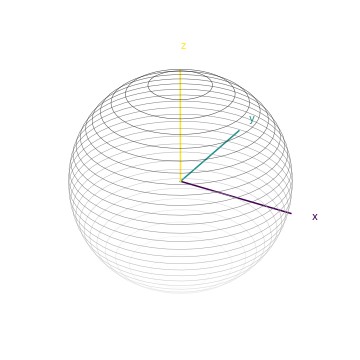

In [36]:
%matplotlib ipympl
render_interactive_guess(example_state.guesses[0])